In [5]:
import numpy as np
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision
from torchsummary import summary 

In [6]:
import matplotlib.pyplot as plt 
%matplotlib inline 

## Reference 
Part of the code in this notebook is taken from the pytorch-cifar repository created by kuangliu.

In [7]:
!git clone https://github.com/kuangliu/pytorch-cifar.git

Cloning into 'pytorch-cifar'...
remote: Enumerating objects: 382, done.
remote: Total 382 (delta 0), reused 0 (delta 0), pack-reused 382
Receiving objects: 100% (382/382), 85.69 KiB | 14.28 MiB/s, done.
Resolving deltas: 100% (195/195), done.


In [8]:
%cd /content/pytorch-cifar/models
from resnet import BasicBlock, Bottleneck, ResNet, ResNet18

/content/pytorch-cifar/models


# Prepare and load CIFAR-10 dataset

In [12]:
trainingdata = torchvision.datasets.CIFAR10('./CIFAR10', train=True, download=True, transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.CIFAR10('./CIFAR10', train=False, download=True, transform=torchvision.transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


In [13]:
print(len(trainingdata))
print(len(testdata))

50000
10000


In [14]:
image, label = trainingdata[0]
print(image.shape, image, label)

torch.Size([3, 32, 32]) tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314, 

# Define train/test functions


In [9]:
def train(model, loss, trainDataLoader, optimizer): 
  train_loss = 0 
  for i, data in enumerate(trainDataLoader):
    images, labels = data 
    images = images.cuda() 
    labels = labels.cuda() 
    optimizer.zero_grad()
    predicted_output = model(images)
    fit = loss(predicted_output, labels)
    fit.backward() 
    optimizer.step() 
    train_loss += fit.item()
  return train_loss / len(trainDataLoader)

In [10]:
def eval(model, loss, testDataLoader):
  test_loss = 0.0 
  correct = 0
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data 
      images = images.cuda() 
      labels = labels.cuda() 
      predicted_output = model(images)
      fit = loss(predicted_output, labels)
      test_loss += fit.item() 
      correct += testDataLoader.batch_size - (torch.argmax(predicted_output, dim=1) - labels).count_nonzero().item()
  return test_loss / len(testDataLoader), correct / len(testdata)

In [11]:
def train_and_test_model(model, loss, trainDataLoader, testDataLoader, optimizer, epoch=20):
  model = model.cuda() 
  train_loss_history = []
  test_loss_history = []
  test_accuracy_history = []
  for ei in range(epoch):
    train_loss = train(model, loss, trainDataLoader, optimizer)
    test_loss, test_accuracy = eval(model, loss, testDataLoader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)
    print('Epoch %s, Train loss %s, Test loss %s, Test accuracy %s'%(ei, train_loss, test_loss, test_accuracy))
  return train_loss_history, test_loss_history, test_accuracy_history

### Helper functions

In [23]:
def plot_result(train_loss_history, test_loss_history, epoch):
  plt.plot(range(epoch),train_loss_history,'-',linewidth=3,label='Train error')
  plt.plot(range(epoch),test_loss_history,'-',linewidth=3,label='Test error')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.grid(True)
  plt.legend()

In [24]:
def plot_accuracy(test_accuracy_history, epoch):
  fig2 = plt.figure("Test acc.")
  plt.plot(range(epoch),test_accuracy_history,'-',linewidth=3,label='Test acc.')
  plt.xlabel('epoch')
  plt.ylabel('acc.')
  plt.grid(True)
  plt.legend()

In [3]:
def best_accuracy(test_accuracy_history):
  print('Highest accuracy:', np.max(test_accuracy_history))

# Experiment with different architectures

###Option 1
4 Residual Layers \

*  Layer 1: 64 channels, 1 residual blocks, kernel size = 3
*  Layer 2: 128 channels, 1 residual blocks, kernel size = 3
*  Layer 3: 256 channels, 1 residual blocks, kernel size = 3
*  Layer 4: 512 channels, 1 residual blocks, kernel size = 3

Total params: 4,903,242 \
Best Acc.: 83.03%

In [51]:
net2 = ResNet(BasicBlock, [1, 1, 1, 1])

In [52]:
summary(net2, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 16, 16]          73,728
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12          [-1, 128, 16, 16]           8,192
      BatchNorm2d-13          [-1, 128, 16, 16]             256
       BasicBlock-14          [-1, 128,

In [53]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)
cross_entropy_loss = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(net2.parameters(), lr=0.001)

In [54]:
train_loss_history, test_loss_history, test_accuracy_history = train_and_test_model(net2, 
                                                                                    cross_entropy_loss, 
                                                                                    trainDataLoader, 
                                                                                    testDataLoader, 
                                                                                    optimizer)

Epoch 0, Train loss 1.2217603720667418, Test loss 0.8998531592879325, Test accuracy 0.6817
Epoch 1, Train loss 0.7596984066240623, Test loss 0.6516416334802178, Test accuracy 0.7804
Epoch 2, Train loss 0.5652555657545929, Test loss 0.5925542829902308, Test accuracy 0.7973
Epoch 3, Train loss 0.4330736103913058, Test loss 0.5450374759306573, Test accuracy 0.8186
Epoch 4, Train loss 0.31546119791086374, Test loss 0.5472259514840545, Test accuracy 0.8219
Epoch 5, Train loss 0.21692293294517281, Test loss 0.5722317438406549, Test accuracy 0.8281
Epoch 6, Train loss 0.14397068714241848, Test loss 0.6107318191581471, Test accuracy 0.8303
Epoch 7, Train loss 0.10798181057014429, Test loss 0.7041372174669982, Test accuracy 0.8213
Epoch 8, Train loss 0.07934092664424225, Test loss 0.7147525361958583, Test accuracy 0.8265
Epoch 9, Train loss 0.0705437014264095, Test loss 0.7612765064095236, Test accuracy 0.8273
Epoch 10, Train loss 0.054726776370988287, Test loss 0.7804402374917534, Test accurac

Highest accuracy: 0.8303


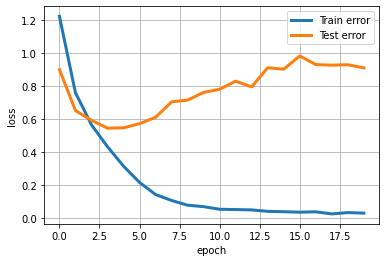

In [55]:
plot_result(train_loss_history, test_loss_history, 20)
best_accuracy(test_accuracy_history)

###Option 2
3 Residual Layers \

*  Layer 1: 32 channels, 5 residual blocks, kernel size = 3
*  Layer 2: 64 channels, 7 residual blocks, kernel size = 3
*  Layer 3: 128 channels, 14 residual blocks, kernel size = 3

Total params: 4,671,146 \
Best Acc.: 86.22%

In [15]:
class ResNet4Layer32(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet4Layer32, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [38]:
net1 = ResNet4Layer32(BasicBlock, [5, 7, 14, 3])

In [39]:
summary(net1, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]           9,216
      BatchNorm2d-14           [-1, 32,

In [40]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)
cross_entropy_loss = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(net1.parameters(), lr=0.001)

In [41]:
train_loss_history, test_loss_history, test_accuracy_history = train_and_test_model(net1, 
                                                                                    cross_entropy_loss, 
                                                                                    trainDataLoader, 
                                                                                    testDataLoader, 
                                                                                    optimizer)

Epoch 0, Train loss 1.5789635028223248, Test loss 1.2331618659055916, Test accuracy 0.5604
Epoch 1, Train loss 1.001835340810249, Test loss 0.8407022694873202, Test accuracy 0.7152
Epoch 2, Train loss 0.7598450535246174, Test loss 0.7241016227728242, Test accuracy 0.7619
Epoch 3, Train loss 0.6014593034182363, Test loss 0.6340764102282798, Test accuracy 0.7856
Epoch 4, Train loss 0.5001547931862609, Test loss 0.5569864721245067, Test accuracy 0.8145
Epoch 5, Train loss 0.41659181725109934, Test loss 0.5050573781797081, Test accuracy 0.8341
Epoch 6, Train loss 0.3437875116915654, Test loss 0.5283913927473081, Test accuracy 0.8248
Epoch 7, Train loss 0.2822689439939416, Test loss 0.5111040609657385, Test accuracy 0.8405
Epoch 8, Train loss 0.22777996548568197, Test loss 0.5081362127308633, Test accuracy 0.8464
Epoch 9, Train loss 0.1797760516986289, Test loss 0.5377909389271098, Test accuracy 0.8465
Epoch 10, Train loss 0.14632707571282105, Test loss 0.5329625057946344, Test accuracy 0.8

Highest accuracy: 0.8622


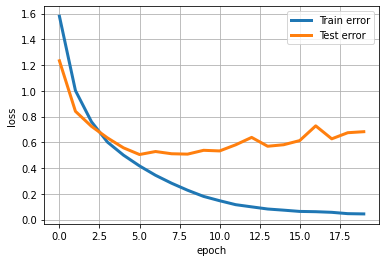

In [50]:
plot_result(train_loss_history, test_loss_history, 20)
best_accuracy(test_accuracy_history)

###Option 3
3 Residual Layers \

*  Layer 1: 64 channels, 2 residual blocks, kernel size = 5
*  Layer 2: 128 channels, 2 residual blocks, kernel size = 5
*  Layer 3: 256 channels, 1 residual blocks, kernel size = 5

Total params: 4,357,194 \
Best Acc.: 87.19%

In [16]:
# Modified BasicBlock to kernel_size=5, padding=2
class BasicBlockK5(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlockK5, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=5, stride=stride, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=5,
                               stride=1, padding=2, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [17]:
# Modified ResNet to have 3 layers instead of 4 layers
class ResNet3Layer(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet3Layer, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.linear = nn.Linear(1024*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [58]:
net3 = ResNet3Layer(BasicBlockK5, [2, 2, 1])

In [59]:
summary(net3, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]         102,400
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]         102,400
       BatchNorm2d-6           [-1, 64, 32, 32]             128
      BasicBlockK5-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]         102,400
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]         102,400
      BatchNorm2d-11           [-1, 64, 32, 32]             128
     BasicBlockK5-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]         204,800
      BatchNorm2d-14          [-1, 128,

In [60]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)
cross_entropy_loss = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(net3.parameters(), lr=0.001)

In [61]:
train_loss_history, test_loss_history, test_accuracy_history = train_and_test_model(net3, 
                                                                                    cross_entropy_loss, 
                                                                                    trainDataLoader, 
                                                                                    testDataLoader, 
                                                                                    optimizer)

Epoch 0, Train loss 1.306595427605807, Test loss 0.9410743918388512, Test accuracy 0.6695
Epoch 1, Train loss 0.8020386247302566, Test loss 0.7081785765802784, Test accuracy 0.7543
Epoch 2, Train loss 0.606662914080693, Test loss 0.6097676541395248, Test accuracy 0.7984
Epoch 3, Train loss 0.48704652640673207, Test loss 0.5570317113855082, Test accuracy 0.8106
Epoch 4, Train loss 0.39728381711503735, Test loss 0.49592233975981453, Test accuracy 0.833
Epoch 5, Train loss 0.31382204000564184, Test loss 0.4513212300979408, Test accuracy 0.8533
Epoch 6, Train loss 0.24432507783765225, Test loss 0.4532086159203463, Test accuracy 0.8547
Epoch 7, Train loss 0.17841566409058202, Test loss 0.47305429048219305, Test accuracy 0.8544
Epoch 8, Train loss 0.12876162910357575, Test loss 0.5322155577551787, Test accuracy 0.8517
Epoch 9, Train loss 0.09148882646732928, Test loss 0.5509313062592677, Test accuracy 0.8519
Epoch 10, Train loss 0.07250696323428522, Test loss 0.5790079998172772, Test accurac

Highest accuracy: 0.8719


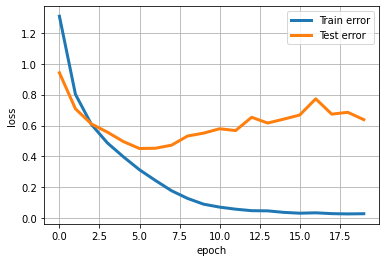

In [62]:
plot_result(train_loss_history, test_loss_history, 20)
best_accuracy(test_accuracy_history)

###Option 4
3 Residual Layers \

*  Layer 1: 64 channels, 3 residual blocks, kernel size = 3
*  Layer 2: 128 channels, 4 residual blocks, kernel size = 3
*  Layer 3: 256 channels, 3 residual blocks, kernel size = 3

Total params: 4,630,858 \
Best Acc.: 85.49%

In [18]:
net4 = ResNet3Layer(BasicBlock, [3, 4, 3])

In [19]:
summary(net4, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [20]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)
cross_entropy_loss = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(net4.parameters(), lr=0.002)

In [21]:
train_loss_history, test_loss_history, test_accuracy_history = train_and_test_model(net4, 
                                                                                    cross_entropy_loss, 
                                                                                    trainDataLoader, 
                                                                                    testDataLoader, 
                                                                                    optimizer)

Epoch 0, Train loss 1.4262277130275736, Test loss 1.0362937495966626, Test accuracy 0.6334
Epoch 1, Train loss 0.8701868013805135, Test loss 0.7493173443967369, Test accuracy 0.7419
Epoch 2, Train loss 0.6336570094384806, Test loss 0.678491479082472, Test accuracy 0.7672
Epoch 3, Train loss 0.49053257084487345, Test loss 0.5607086594697017, Test accuracy 0.8155
Epoch 4, Train loss 0.3830929309930033, Test loss 0.4877913029520375, Test accuracy 0.8415
Epoch 5, Train loss 0.2861999039207121, Test loss 0.48614588019194876, Test accuracy 0.8466
Epoch 6, Train loss 0.20763215443114644, Test loss 0.5092119607765964, Test accuracy 0.8508
Epoch 7, Train loss 0.13909016388094486, Test loss 0.5433637751325681, Test accuracy 0.8519
Epoch 8, Train loss 0.10725820294755233, Test loss 0.605370361524023, Test accuracy 0.844
Epoch 9, Train loss 0.07945458287500617, Test loss 0.6399989602672067, Test accuracy 0.8473
Epoch 10, Train loss 0.06469304883874039, Test loss 0.6837016666770741, Test accuracy 0

Highest accuracy: 0.8549


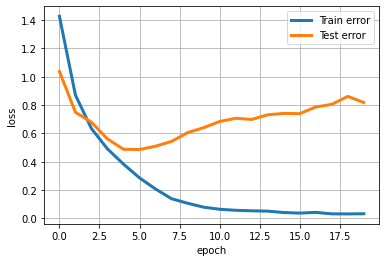

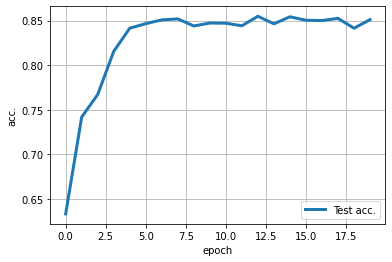

In [25]:
plot_result(train_loss_history, test_loss_history, 20)
plot_accuracy(test_accuracy_history, 20)
best_accuracy(test_accuracy_history)

###Option 5
3 Residual Layers \

*  Layer 1: 128 channels, 1 residual blocks, kernel size = 3
*  Layer 2: 256 channels, 1 residual blocks, kernel size = 3
*  Layer 3: 512 channels, 1 residual blocks, kernel size = 3

Total params: 4,911,754 \
Best Acc.: 85.24%

In [27]:
# Modified ResNet to have 3 layers instead of 4 layers 
# first layer has 128 channels
class ResNet3Layer128(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet3Layer128, self).__init__()
        self.in_planes = 128

        self.conv1 = nn.Conv2d(3, 128, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(128)
        self.layer1 = self._make_layer(block, 128, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 256, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 512, num_blocks[2], stride=2)
        self.linear = nn.Linear(2048*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [64]:
net5 = ResNet3Layer128(BasicBlock, [1, 1, 1])

In [65]:
summary(net5, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,456
       BatchNorm2d-2          [-1, 128, 32, 32]             256
            Conv2d-3          [-1, 128, 32, 32]         147,456
       BatchNorm2d-4          [-1, 128, 32, 32]             256
            Conv2d-5          [-1, 128, 32, 32]         147,456
       BatchNorm2d-6          [-1, 128, 32, 32]             256
        BasicBlock-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 256, 16, 16]         294,912
       BatchNorm2d-9          [-1, 256, 16, 16]             512
           Conv2d-10          [-1, 256, 16, 16]         589,824
      BatchNorm2d-11          [-1, 256, 16, 16]             512
           Conv2d-12          [-1, 256, 16, 16]          32,768
      BatchNorm2d-13          [-1, 256, 16, 16]             512
       BasicBlock-14          [-1, 256,

In [66]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)
cross_entropy_loss = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(net5.parameters(), lr=0.001)

In [67]:
train_loss_history, test_loss_history, test_accuracy_history = train_and_test_model(net5, 
                                                                                    cross_entropy_loss, 
                                                                                    trainDataLoader, 
                                                                                    testDataLoader, 
                                                                                    optimizer)

Epoch 0, Train loss 1.2153349728383067, Test loss 0.9312290598632423, Test accuracy 0.6798
Epoch 1, Train loss 0.7547877853178917, Test loss 0.6833569863039977, Test accuracy 0.7689
Epoch 2, Train loss 0.5876260639532752, Test loss 0.5975609721651503, Test accuracy 0.8046
Epoch 3, Train loss 0.4614087881715706, Test loss 0.551774931751239, Test accuracy 0.8202
Epoch 4, Train loss 0.3543397191807132, Test loss 0.5121317334046029, Test accuracy 0.8325
Epoch 5, Train loss 0.2654692434212741, Test loss 0.5430426216049559, Test accuracy 0.8352
Epoch 6, Train loss 0.1762078426816427, Test loss 0.5493318374939026, Test accuracy 0.8402
Epoch 7, Train loss 0.1118456521440688, Test loss 0.5750621675875536, Test accuracy 0.8378
Epoch 8, Train loss 0.07806682678968514, Test loss 0.6084256044998291, Test accuracy 0.8446
Epoch 9, Train loss 0.06491067336367258, Test loss 0.6302334876007335, Test accuracy 0.8417
Epoch 10, Train loss 0.05222037429963012, Test loss 0.6872027305660734, Test accuracy 0.8

Highest accuracy: 0.8524


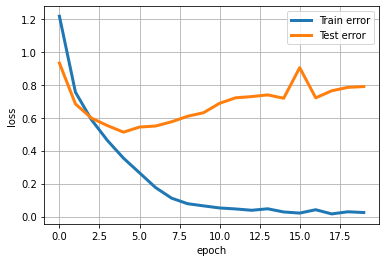

In [68]:
plot_result(train_loss_history, test_loss_history, 20)
best_accuracy(test_accuracy_history)

###Option 6
3 Residual Layers \

*  Layer 1: 64 channels, 5 residual blocks, kernel size = 3
*  Layer 2: 128 channels, 3 residual blocks, kernel size = 3
*  Layer 3: 256 channels, 3 residual blocks, kernel size = 3

Total params: 4,483,402 \
Best Acc.: 85.96%

In [69]:
net6 = ResNet3Layer(BasicBlock, [5, 3, 3])

In [70]:
summary(net6, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [71]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)
cross_entropy_loss = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(net6.parameters(), lr=0.001)

In [72]:
train_loss_history, test_loss_history, test_accuracy_history = train_and_test_model(net6, 
                                                                                    cross_entropy_loss, 
                                                                                    trainDataLoader, 
                                                                                    testDataLoader, 
                                                                                    optimizer)

Epoch 0, Train loss 1.4091167936239706, Test loss 1.052902641569733, Test accuracy 0.6253
Epoch 1, Train loss 0.8503743754628369, Test loss 0.7414057205437096, Test accuracy 0.7553
Epoch 2, Train loss 0.6213975958811963, Test loss 0.6431558046750961, Test accuracy 0.7868
Epoch 3, Train loss 0.49185128452832744, Test loss 0.5424484261281931, Test accuracy 0.8203
Epoch 4, Train loss 0.39416903236409284, Test loss 0.5100873485682117, Test accuracy 0.8348
Epoch 5, Train loss 0.3123827419336647, Test loss 0.49923599164956695, Test accuracy 0.8432
Epoch 6, Train loss 0.24049382176621795, Test loss 0.4864379936342786, Test accuracy 0.8516
Epoch 7, Train loss 0.1797758547489143, Test loss 0.5256916163073984, Test accuracy 0.8486
Epoch 8, Train loss 0.13004869695924356, Test loss 0.5681887645820144, Test accuracy 0.853
Epoch 9, Train loss 0.10021080566412957, Test loss 0.5792900785139412, Test accuracy 0.8555
Epoch 10, Train loss 0.07729689921121426, Test loss 0.6112572118450122, Test accuracy 

Highest accuracy: 0.8596


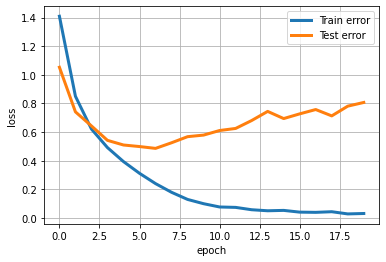

In [73]:
plot_result(train_loss_history, test_loss_history, 20)
best_accuracy(test_accuracy_history)

###Option 7 (BEST)
2 Residual Layers \

*  Layer 1: 64 channels, 5 residual blocks, kernel size = 5
*  Layer 2: 128 channels, 2 residual blocks, kernel size = 7

Total params: 3,851,594 \
Best Acc.: 88.39%

In [28]:
# Modified BasicBlock to kernel_size=5, padding=2
class BasicBlockK7(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlockK7, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=7, stride=stride, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=7,
                               stride=1, padding=3, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [29]:
# TODO: match up matrix dimensions 
class ResNet2LayerK3K7(nn.Module):
    def __init__(self, block1, block2, num_blocks, num_classes=10):
        super(ResNet2LayerK3K7, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block1, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block2, 128, num_blocks[1], stride=2)
        self.linear = nn.Linear(512*block2.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [76]:
net7 = ResNet2LayerK3K7(BasicBlockK5, BasicBlockK7, [5, 2])

In [77]:
summary(net7, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]         102,400
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]         102,400
       BatchNorm2d-6           [-1, 64, 32, 32]             128
      BasicBlockK5-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]         102,400
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]         102,400
      BatchNorm2d-11           [-1, 64, 32, 32]             128
     BasicBlockK5-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]         102,400
      BatchNorm2d-14           [-1, 64,

In [78]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)
cross_entropy_loss = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(net7.parameters(), lr=0.001)

In [79]:
train_loss_history, test_loss_history, test_accuracy_history = train_and_test_model(net7, 
                                                                                    cross_entropy_loss, 
                                                                                    trainDataLoader, 
                                                                                    testDataLoader, 
                                                                                    optimizer,
                                                                                    epoch=40)

Epoch 0, Train loss 1.3837213087112397, Test loss 1.0545465433673493, Test accuracy 0.6291
Epoch 1, Train loss 0.887517499230097, Test loss 0.8231238354543212, Test accuracy 0.7174
Epoch 2, Train loss 0.6744059546448081, Test loss 0.6238865269597169, Test accuracy 0.7898
Epoch 3, Train loss 0.5424955959057869, Test loss 0.5844560789454515, Test accuracy 0.8029
Epoch 4, Train loss 0.45474261923900344, Test loss 0.5071727809063189, Test accuracy 0.8299
Epoch 5, Train loss 0.37383806206228787, Test loss 0.47824417813948006, Test accuracy 0.8422
Epoch 6, Train loss 0.3131528169278751, Test loss 0.44794645203146966, Test accuracy 0.8526
Epoch 7, Train loss 0.25216343051865886, Test loss 0.43265552733354506, Test accuracy 0.8611
Epoch 8, Train loss 0.2060877097594311, Test loss 0.4728463677938577, Test accuracy 0.8542
Epoch 9, Train loss 0.16265259708856683, Test loss 0.43666643549682227, Test accuracy 0.8675
Epoch 10, Train loss 0.12592508985191736, Test loss 0.46567287490626047, Test accur

Highest accuracy: 0.8839


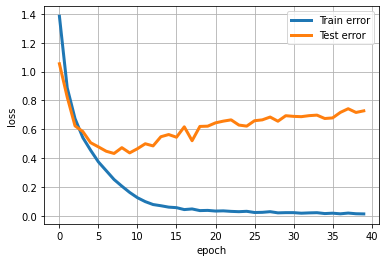

In [80]:
plot_result(train_loss_history, test_loss_history, 40)
best_accuracy(test_accuracy_history)

###Option 8 (BEST)
2 Residual Layers \

*  Layer 1: 128 channels, 2 residual blocks, kernel size = 3
*  Layer 2: 256 channels, 3 residual blocks, kernel size = 3

Total params: 3,885,194 \
Best Acc.: 88.47%

In [81]:
# TODO: match up matrix dimensions 
class ResNet2Layer(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet2Layer, self).__init__()
        self.in_planes = 128

        self.conv1 = nn.Conv2d(3, 128, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(128)
        self.layer1 = self._make_layer(block, 128, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 256, num_blocks[1], stride=2)
        self.linear = nn.Linear(1024*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [82]:
net8 = ResNet2Layer(BasicBlock, [2, 3])

In [83]:
summary(net8, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,456
       BatchNorm2d-2          [-1, 128, 32, 32]             256
            Conv2d-3          [-1, 128, 32, 32]         147,456
       BatchNorm2d-4          [-1, 128, 32, 32]             256
            Conv2d-5          [-1, 128, 32, 32]         147,456
       BatchNorm2d-6          [-1, 128, 32, 32]             256
        BasicBlock-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,456
       BatchNorm2d-9          [-1, 128, 32, 32]             256
           Conv2d-10          [-1, 128, 32, 32]         147,456
      BatchNorm2d-11          [-1, 128, 32, 32]             256
       BasicBlock-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 16, 16]         294,912
      BatchNorm2d-14          [-1, 256,

In [84]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)
cross_entropy_loss = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(net8.parameters(), lr=0.001)

In [85]:
train_loss_history, test_loss_history, test_accuracy_history = train_and_test_model(net8, 
                                                                                    cross_entropy_loss, 
                                                                                    trainDataLoader, 
                                                                                    testDataLoader, 
                                                                                    optimizer,
                                                                                    epoch=50)

Epoch 0, Train loss 1.2881071325153342, Test loss 0.9978550410574409, Test accuracy 0.6513
Epoch 1, Train loss 0.7810898901861342, Test loss 0.7236365058999152, Test accuracy 0.7511
Epoch 2, Train loss 0.6005596585971925, Test loss 0.5955518897931287, Test accuracy 0.7973
Epoch 3, Train loss 0.4886214337347414, Test loss 0.5133435710979875, Test accuracy 0.8308
Epoch 4, Train loss 0.3996119108765631, Test loss 0.4810009279828163, Test accuracy 0.8455
Epoch 5, Train loss 0.3328304901680983, Test loss 0.4948399932521164, Test accuracy 0.8417
Epoch 6, Train loss 0.2629169265327551, Test loss 0.45580558943900334, Test accuracy 0.8579
Epoch 7, Train loss 0.20660781189132377, Test loss 0.42490107836617025, Test accuracy 0.8719
Epoch 8, Train loss 0.15859774199655027, Test loss 0.4608215302418751, Test accuracy 0.8665
Epoch 9, Train loss 0.12483874577409623, Test loss 0.47775972345072754, Test accuracy 0.8685
Epoch 10, Train loss 0.09664718573436598, Test loss 0.5304596988828318, Test accurac

Highest accuracy: 0.8847


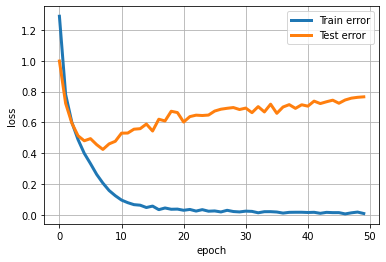

In [86]:
plot_result(train_loss_history, test_loss_history, 50)
best_accuracy(test_accuracy_history)

###Option 9 (BEST)
2 Residual Layers \

*  Layer 1: 64 channels, 6 residual blocks, kernel size = 3
*  Layer 2: 128 channels, 3 residual blocks, kernel size = 7

Total params: 4,876,362 \
Best Acc.: 88.56%

In [32]:
net10 = ResNet2LayerK3K7(BasicBlock, BasicBlockK7, [6, 3])

In [33]:
summary(net10, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [34]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)
cross_entropy_loss = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(net10.parameters(), lr=0.001)

In [35]:
train_loss_history, test_loss_history, test_accuracy_history = train_and_test_model(net10, 
                                                                                    cross_entropy_loss, 
                                                                                    trainDataLoader, 
                                                                                    testDataLoader, 
                                                                                    optimizer,
                                                                                    epoch=40)

Epoch 0, Train loss 1.2588961055059262, Test loss 0.8899344262803436, Test accuracy 0.6902
Epoch 1, Train loss 0.7448249532438606, Test loss 0.6620994176074957, Test accuracy 0.7732
Epoch 2, Train loss 0.5655425615475306, Test loss 0.5336481932621853, Test accuracy 0.82
Epoch 3, Train loss 0.45147004271940805, Test loss 0.49004723198094946, Test accuracy 0.8356
Epoch 4, Train loss 0.3706730792437063, Test loss 0.47916060728821785, Test accuracy 0.8429
Epoch 5, Train loss 0.29943185438737846, Test loss 0.4310169753375327, Test accuracy 0.8645
Epoch 6, Train loss 0.2363123550315571, Test loss 0.4521609160835576, Test accuracy 0.8576
Epoch 7, Train loss 0.18519450166760504, Test loss 0.44391510735271844, Test accuracy 0.8666
Epoch 8, Train loss 0.14349615000917212, Test loss 0.43824524541569365, Test accuracy 0.8726
Epoch 9, Train loss 0.10865185062146133, Test loss 0.466034674530576, Test accuracy 0.8758
Epoch 10, Train loss 0.08775816771232754, Test loss 0.49990808897337335, Test accura

Highest accuracy: 0.8856


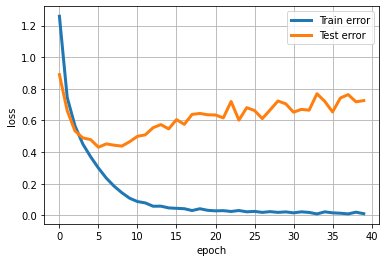

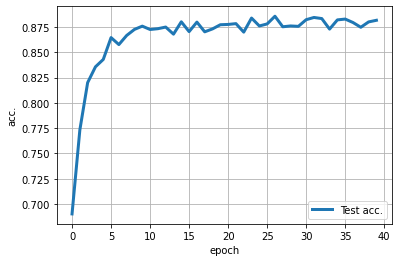

In [36]:
plot_result(train_loss_history, test_loss_history, 40)
plot_accuracy(test_accuracy_history, 40)
best_accuracy(test_accuracy_history)

###Option 10
2 Residual Layers \

*  Layer 1: 128 channels, 3 residual blocks, kernel size = 3
*  Layer 2: 256 channels, 2 residual blocks, kernel size = 5

Total params: 926,282 \
Best Acc.: 87.28%

In [87]:
net9 = ResNet2LayerK3K7(BasicBlock, BasicBlockK5, [4, 1])

In [88]:
summary(net9, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [89]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)
cross_entropy_loss = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(net9.parameters(), lr=0.001, weight_decay=1e-4)

In [90]:
train_loss_history, test_loss_history, test_accuracy_history = train_and_test_model(net9, 
                                                                                    cross_entropy_loss, 
                                                                                    trainDataLoader, 
                                                                                    testDataLoader, 
                                                                                    optimizer,
                                                                                    epoch=100)

Epoch 0, Train loss 1.2620947062969208, Test loss 1.001976356005213, Test accuracy 0.6423
Epoch 1, Train loss 0.8319855155161274, Test loss 0.7599449930297342, Test accuracy 0.7457
Epoch 2, Train loss 0.6724394974120133, Test loss 0.6197444441591858, Test accuracy 0.7928
Epoch 3, Train loss 0.5703709899159648, Test loss 0.5924189870904206, Test accuracy 0.7977
Epoch 4, Train loss 0.49824689549710743, Test loss 0.5089381255541637, Test accuracy 0.8308
Epoch 5, Train loss 0.4401849094406723, Test loss 0.4985731059958221, Test accuracy 0.8324
Epoch 6, Train loss 0.3920008964322107, Test loss 0.4886188478606522, Test accuracy 0.8355
Epoch 7, Train loss 0.3560516153416975, Test loss 0.4676876917576334, Test accuracy 0.8446
Epoch 8, Train loss 0.3175416584210018, Test loss 0.4619760804685058, Test accuracy 0.8458
Epoch 9, Train loss 0.2900226227748577, Test loss 0.45276441667110295, Test accuracy 0.8554
Epoch 10, Train loss 0.2608388304672278, Test loss 0.4437857721072094, Test accuracy 0.85

Highest accuracy: 0.8728


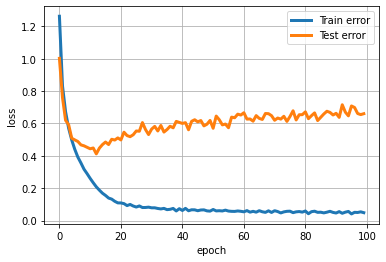

In [91]:
plot_result(train_loss_history, test_loss_history, 100)
best_accuracy(test_accuracy_history)